OSE scentific computation final report  WS 2020/2021 Bonn University
Title
author: Po-Tse Cheng

In [2]:
import numpy as np 
import pandas as pd
import math
import time
import seaborn as sns
import matplotlib.pyplot as plt

from tools.auxiliary import*
from tools.GH_Quadrature import*
from tools.Ord_Herm_Pol_1 import*
from tools.Main_Results import*
from tools.Accuracy_Test_1 import*
from tools.Num_Stab_Approx_new import*

This notebook contains the python implementation of the General Stochastic Simulation Algorithm (GSSA), developed by Kenneth L. Judde et. al (2011). 

In [3]:
df =reading("epsi10000.csv")
T  = 10000           #Choose the simulation length for the solution procedure, T<=10,000                    
gam     = 1        # Utility-function parameter
alpha   = 0.36     # Capital share in output
beta    = 0.99     # Discount factor
delta   = 0.02     # Depreciation rate 
rho     = 0.95     # Persistence of the log of the productivity level
sigma   = 0.01    # Standard deviation of shocks to the log of the productivity level
ks = ( (1-beta+beta*delta) / (alpha*beta) )**(1/(alpha-1) )
k = np.array([ks]*(T+1))
a= [1]*(T)
epsi = df.iloc[:,0].astype(float)*sigma
epsi=epsi.tolist()
for i in range(1, T):
    a[i]=a[i-1]**(rho)*math.exp(epsi[i])
a=np.asarray(a)
kdamp = 0.01    
dif_GSSA_1d = 1e+10  
bk_1d  = np.array([0., 0.95, ks*0.05])
bk_1d= np.reshape(bk_1d, (3,1))
k_old = [ks+1]*(T+1)

In [4]:
start = time.time()
y= GSSA_main_cycle(T, gam, alpha, beta, delta, kdamp, dif_GSSA_1d, a, bk_1d, k_old, k)
end = time.time()
elapsed_time = end-start

In [5]:
y = y.reshape((y.shape[0],1)) #make sure y is in the right shape
#The GSSA parameters

kdamp = 0.1
dif_GSSA_D = 1e+10

#The matrices of the polynomial coefficients
D_max  = 5 #because of python
npol = np.array([3, 6, 10, 15, 21])

# 13. Choose an integration method for computing solutions  
IM  = 10

n_nodes,epsi_nodes, weight_nodes= GH_Quadrature(Qn=10, N=1, vcv=sigma**2)

#make sure to change a into the right shape
a = np.reshape(a, (T, 1))
a1 = np.matmul(np.power(a,rho), np.exp(epsi_nodes.transpose()))

#14. Choose a regression specification 
RM = 6           # Choose a regression method: 
                 # 1=OLS,          2=LS-SVD,   3=LAD-PP,  4=LAD-DP, 
                 # 5=RLS-Tikhonov, 6=RLS-TSVD, 7=RLAD-PP, 8=RLAD-DP
normalize = 1    # Option of normalizing the data; 0=unnormalized data; 
                 # 1=normalized data                    
penalty = 7      # Degree of regularization for a regularization methods, 
                 # RM=5,6,7,8 (must be negative, e.g., -7 for RM=5,7,8 
                 # and must be positive, e.g., 7, for RM=6)
PF = 0           # Choose a polynomial family; 0=Ordinary (default);  
                 # 1=Hermite
# 15. Initialize the capital series
zb = np.matrix([[np.mean(k[0:T]), np.mean(a[0:T])], [np.std(k[0:T]), np.std(a[0:T])]])
z = np.concatenate((k[0:T].reshape(T,1), a[0:T].reshape(T,1)), axis=1)
k_old = [ks+1]*(T+1)

In [6]:
BK = []
Time = []
for d in range(1, D_max+1):
    start = time.time()
    BK.append(GSSA_poly(T, a, z, d, PF, zb, RM, penalty, normalize, dif_GSSA_D, kdamp, alpha, beta, delta, k, gam, y, k_old, a1, IM, n_nodes, weight_nodes, checker= 0))
    end = time.time()
    Time.append(end-start)

In [7]:
T_test = 10200

df =reading("epsi_test.csv")
epsi_test = sigma*df.to_numpy().astype(float)
a_test = [1]
for i in range(1,T_test):
    value = a_test[i-1]**(rho)*math.exp(float(epsi_test[i]))
    a_test.append(value)

IM_test = 10

k_test = [ks]
result_max = []
result_mean = []
result_time = []
for d in range(1, D_max+1):
    #refressing k_test to make sure that k_test is always 10200
    #k_test = [ks]
    for i in range(T_test):
        X_test = Ord_Herm_Pol_1(np.array([k_test[i], a_test[i]]).reshape([1,2]),d,PF,zb) # D = 1 for now, we will plug this in another for loop
        value = float(np.matmul(X_test, BK[d-1]))
        k_test.append(value)

        # testing it below
    discard = 200 #new defined value
    mean_error, max_error, error_time = Accuracy_Test_1(sigma,rho,beta,gam,alpha,delta,k_test,a_test,BK[d-1],d,IM_test,PF,zb,discard)
    result_max.append(max_error)
    result_mean.append(mean_error)
    result_time.append(error_time)

In [8]:

#construct df for ploting
showcase_result = pd.DataFrame(result_max, columns=["Maximum Error"])
showcase_result["Mean Error"] = result_mean
showcase_result["Time"] = Time
showcase_result["Error Time"] = result_time
showcase_result["Polynomial Degree"]= list(range(1,6))
showcase_result["Total Time"] = showcase_result["Error Time"] + showcase_result["Time"]
showcase_result["Rounded Total Time"]=showcase_result["Total Time"].round(decimals=2)
showcase_result["Original Mean Error"]= 10**(showcase_result["Mean Error"])
showcase_result["Original Max Error"]= 10**(showcase_result["Maximum Error"])
showcase_result.set_index(["Polynomial Degree"])

,Maximum Error,Mean Error,Time,Error Time,Total Time,Rounded Total Time,Original Mean Error,Original Max Error
Polynomial Degree,,,,,,,,
1,-3.366134,-4.358702,29.372405,0.981375,30.353780,30.35,4.378225e-05,4.303938e-04
2,-4.883611,-6.118154,46.368052,0.846734,47.214786,47.21,7.618090e-07,1.307343e-05
3,-5.951989,-7.481158,69.905025,0.921533,70.826558,70.83,3.302497e-08,1.116891e-06
4,-7.021109,-8.716908,96.813945,1.080110,97.894055,97.89,1.919073e-09,9.525560e-08
5,-8.071298,-9.920923,133.652369,1.442141,135.094510,135.09,1.199712e-10,8.485980e-09


<AxesSubplot:label='b3ab96b2-a49c-4452-9983-b427ce15cc81', xlabel='Rounded Total Time', ylabel='Mean Error'>

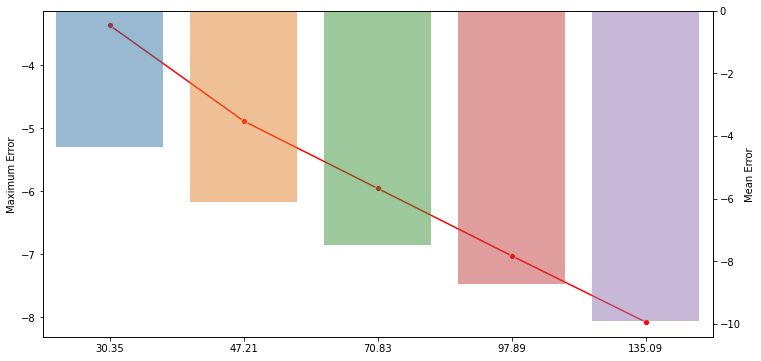

In [9]:
#plot with regards to time, maxi for visualisation
# add title and so on
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = showcase_result["Maximum Error"], marker='o', ax=ax1, color='r')
ax2 = ax1.twinx()

sns.barplot(data = showcase_result, x="Rounded Total Time", y="Mean Error", alpha=0.5, ax=ax2)

In [2]:
df =reading("epsi10000.csv")
T  = 10000           #Choose the simulation length for the solution procedure, T<=10,000                    
gam     = 1        # Utility-function parameter
alpha   = 0.36     # Capital share in output
beta    = 0.99     # Discount factor
delta   = 0.02     # Depreciation rate 
rho     = 0.95     # Persistence of the log of the productivity level
sigma   = 0.01    # Standard deviation of shocks to the log of the productivity level
ks = ( (1-beta+beta*delta) / (alpha*beta) )**(1/(alpha-1) )
k = np.array([ks]*(T+1))
a= [1]*(T)
epsi = df.iloc[:,0].astype(float)*sigma
epsi=epsi.tolist()
for i in range(1, T):
    a[i]=a[i-1]**(rho)*math.exp(epsi[i])
a=np.asarray(a)
kdamp = 0.01    
dif_GSSA_1d = 1e+10  
bk_1d  = np.array([0., 0.95, ks*0.05])
bk_1d= np.reshape(bk_1d, (3,1))
k_old = [ks+1]*(T+1)
start = time.time()
y= GSSA_main_cycle(T, gam, alpha, beta, delta, kdamp, dif_GSSA_1d, a, bk_1d, k_old, k)
end = time.time()
elapsed_time = end-start
y = y.reshape((y.shape[0],1)) #make sure y is in the right shape
#The GSSA parameters

kdamp = 0.1
dif_GSSA_D = 1e+10

#The matrices of the polynomial coefficients
D_max  = 5 #because of python
npol = np.array([3, 6, 10, 15, 21])

# 13. Choose an integration method for computing solutions  
IM  = 10

n_nodes,epsi_nodes, weight_nodes= GH_Quadrature(Qn=10, N=1, vcv=sigma**2)

#make sure to change a into the right shape
a = np.reshape(a, (T, 1))
a1 = np.matmul(np.power(a,rho), np.exp(epsi_nodes.transpose()))

#14. Choose a regression specification 
RM = 5           # Choose a regression method: 
                 # 1=OLS,          2=LS-SVD,   3=LAD-PP,  4=LAD-DP, 
                 # 5=RLS-Tikhonov, 6=RLS-TSVD, 7=RLAD-PP, 8=RLAD-DP
normalize = 0    # Option of normalizing the data; 0=unnormalized data; 
                 # 1=normalized data                    
penalty = -7      # Degree of regularization for a regularization methods, 
                 # RM=5,6,7,8 (must be negative, e.g., -7 for RM=5,7,8 
                 # and must be positive, e.g., 7, for RM=6)
PF = 0           # Choose a polynomial family; 0=Ordinary (default);  
                 # 1=Hermite
# 15. Initialize the capital series
zb = np.matrix([[np.mean(k[0:T]), np.mean(a[0:T])], [np.std(k[0:T]), np.std(a[0:T])]])
z = np.concatenate((k[0:T].reshape(T,1), a[0:T].reshape(T,1)), axis=1)
k_old = [ks+1]*(T+1)
BK = []
Time = []



In [3]:
for d in range(1, D_max+1):
    start = time.time()
    BK.append(GSSA_poly(T, a, z, d, PF, zb, RM, penalty, normalize, dif_GSSA_D, kdamp, alpha, beta, delta, k, gam, y, k_old, a1, IM, n_nodes, weight_nodes, checker= 1))
    end = time.time()
    Time.append(end-start)

0.035193270265045144
0.00012850550682548306
0.00011964777527605584
0.00011145127452005383
0.00010385937142574305
9.682124227868838e-05
9.029116532804916e-05
8.422791080630167e-05
7.859421411006879e-05
7.335631948499626e-05
6.84835842013509e-05
6.394813428333873e-05
5.9724564320231975e-05
5.5789675482520095e-05
5.212224591741052e-05
4.870282944112143e-05
4.5513578345212686e-05
4.2538087248555174e-05
3.976125517960732e-05
3.7169163332001674e-05
3.474896644248455e-05
3.2488796337477186e-05
3.037767567410254e-05
2.84054409270225e-05
2.6562673268865064e-05
2.4840636478269035e-05
2.3231221121558677e-05
2.172689400747121e-05
2.0320652541496114e-05
1.9005983381992243e-05
1.7776824832060655e-05
1.6627532526440068e-05
1.5552848337400273e-05
1.454787174736424e-05
1.3608033768339027e-05
1.2729073002765555e-05
1.190701362560748e-05
1.1138145165921334e-05
1.0419003883990297e-05
9.74635558999956e-06
9.117179736549148e-06
8.528654811894735e-06
7.978144716119891e-06
7.463186156649713e-06
6.981477107523

KeyboardInterrupt: 

In [4]:
d = 5
BK.append(GSSA_poly(T, a, z, d, PF, zb, RM, penalty, normalize, dif_GSSA_D, kdamp, alpha, beta, delta, k, gam, y, k_old, a1, IM, n_nodes, weight_nodes, checker= 1))

0.03554286830237672
0.00027909951111531163
0.0002031550235095941
0.00016280375488219144
0.00013497259769083966
0.00011576783492192506
0.00010155769979495865
9.059467932930031e-05
8.297914920393032e-05
7.677087375120924e-05
7.03837159107058e-05
6.55745257489006e-05
6.110177400853847e-05
5.6948791947552734e-05
5.3295054556164596e-05
4.9703341978593354e-05
4.6487018094455754e-05
4.35547466339245e-05
4.051786381947284e-05
3.7912275853993706e-05
3.55455218087945e-05
3.31805655741037e-05
3.103380347587188e-05
2.901904692351637e-05
2.716679487716985e-05
2.53611279424686e-05
2.3682624224962862e-05
2.213472859988549e-05
2.0718221592830626e-05
1.9385880926596628e-05
1.8107469958547265e-05
1.694683167369167e-05
1.583209690957065e-05
1.4820858459854256e-05
1.3851935216590742e-05
1.2960429152708526e-05
1.212883065382222e-05
1.1346041291818222e-05
1.0608687360605626e-05
9.941014985501763e-06
9.293331034507556e-06
8.700290371415626e-06
8.138701939607562e-06
7.6165209879300175e-06
7.1362250118707166e-

KeyboardInterrupt: 

In [ ]:
T_test = 10200

df =reading("epsi_test.csv")
epsi_test = sigma*df.to_numpy().astype(float)
a_test = [1]
for i in range(1,T_test):
    value = a_test[i-1]**(rho)*math.exp(float(epsi_test[i]))
    a_test.append(value)

IM_test = 10

k_test = [ks]
result_max = []
result_mean = []
result_time = []
for d in range(1, D_max+1):
    #refressing k_test to make sure that k_test is always 10200
    #k_test = [ks]
    for i in range(T_test):
        X_test = Ord_Herm_Pol_1(np.array([k_test[i], a_test[i]]).reshape([1,2]),d,PF,zb) # D = 1 for now, we will plug this in another for loop
        value = float(np.matmul(X_test, BK[d-1]))
        k_test.append(value)

        # testing it below
    discard = 200 #new defined value
    mean_error, max_error, error_time = Accuracy_Test_1(sigma,rho,beta,gam,alpha,delta,k_test,a_test,BK[d-1],d,IM_test,PF,zb,discard)
    result_max.append(max_error)
    result_mean.append(mean_error)
    result_time.append(error_time)

#construct df for ploting
showcase_result = pd.DataFrame(result_max, columns=["Maximum Error"])
showcase_result["Mean Error"] = result_mean
showcase_result["Time"] = Time
showcase_result["Error Time"] = result_time
showcase_result["Polynomial Degree"]= list(range(1,6))
showcase_result["Total Time"] = showcase_result["Error Time"] + showcase_result["Time"]
showcase_result["Rounded Total Time"]=showcase_result["Total Time"].round(decimals=2)
showcase_result["Original Mean Error"]= 10**(showcase_result["Mean Error"])
showcase_result["Original Max Error"]= 10**(showcase_result["Maximum Error"])
showcase_result.set_index(["Polynomial Degree"])
#plot with regards to time, maxi for visualisation
# add title and so on
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = showcase_result["Maximum Error"], marker='o', ax=ax1, color='r')
ax2 = ax1.twinx()

sns.barplot(data = showcase_result, x="Rounded Total Time", y="Mean Error", alpha=0.5, ax=ax2)